In [1]:
import csv
import os
import pandas as pd
from collections import Counter
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', lambda x: '%.3f' % x)


from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB, MultinomialNB, BernoulliNB


# Predictiong Graph in 2012

* Load training and testing dataframes

In [2]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2012/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2012/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,0.229,0.114,153.452,28.477,2.767,1.498,0.972,0.027,5.495,5.495,1.943,755.500
1,0.160,0.080,102.223,18.763,1.954,1.843,0.948,0.035,3.491,3.491,1.897,654.000
2,0.436,0.218,181.423,34.631,3.271,1.399,0.980,0.025,7.416,7.416,1.960,815.500
3,0.433,0.217,208.498,38.412,3.759,1.331,0.983,0.024,7.586,7.586,1.966,807.000
4,0.336,0.168,153.199,29.182,2.762,1.522,0.981,0.027,6.115,6.115,1.962,759.000


In [3]:
Y_test.shape

(254704,)

In [6]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  154636
Negative_samples:  12753


### Up-Sampling

In [62]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [5]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [6]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [17]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [18]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [19]:
prediction = classifier.predict(X_test)

In [20]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.881
1,Precision,0.891
2,Recall,0.986
3,FPR,0.909
4,FNR,0.014
5,F1,0.936


'Feature Importance'

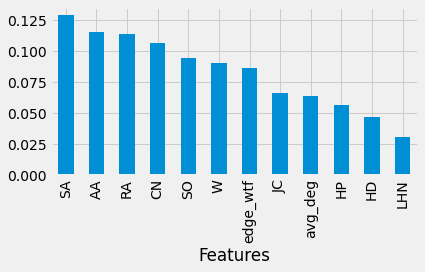

In [11]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)

## Predictiong Graph in 2013

#### load dataset

In [5]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2013/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2013/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,5.052,2.176,736.846,120.079,2.021,1.927,0.986,0.005,20.899,20.899,1.973,1233.500
1,0.755,0.325,450.056,69.905,4.708,1.234,0.978,0.013,8.519,8.519,1.956,994.500
2,1.285,0.554,507.091,81.943,3.434,1.391,0.990,0.009,12.763,12.763,1.980,1140.500
3,2.694,1.160,622.553,102.467,2.355,1.708,0.990,0.006,18.039,18.039,1.980,1193.000
4,2.580,1.111,606.818,99.336,2.445,1.664,0.990,0.007,16.622,16.622,1.981,1175.000


In [6]:
X_test.shape

(345528, 12)

In [34]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  224744
Negative_samples:  29960


### Up-Sampling

In [32]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [35]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [36]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [37]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [38]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [39]:
prediction = classifier.predict(X_test)

In [40]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.871
1,Precision,0.894
2,Recall,0.968
3,FPR,0.831
4,FNR,0.032
5,F1,0.930


'Feature Importance'

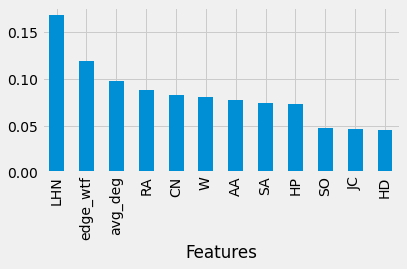

In [41]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)


## Predictiong Graph in 2014

#### load dataset

In [8]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2014/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2014/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,1.717,0.664,711.175,103.786,2.077,1.889,0.989,0.006,12.375,12.375,1.979,1273.500
1,0.408,0.158,435.832,61.455,4.154,1.273,0.974,0.012,5.460,5.460,1.949,1063.000
2,1.213,0.469,579.564,84.289,2.376,1.693,0.989,0.007,9.822,9.822,1.977,1213.000
3,0.144,0.056,351.379,47.210,10.534,1.026,0.935,0.031,3.360,3.360,1.871,868.500
4,3.307,1.279,606.167,86.695,2.234,1.771,0.988,0.007,10.074,10.074,1.975,1160.000


In [9]:
X_test.shape

(569807, 12)

In [43]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  303579
Negative_samples:  41949


### Up-Sampling

In [ ]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [44]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [45]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [46]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [47]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [48]:
prediction = classifier.predict(X_test)

In [49]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.909
1,Precision,0.956
2,Recall,0.946
3,FPR,0.643
4,FNR,0.054
5,F1,0.951


'Feature Importance'

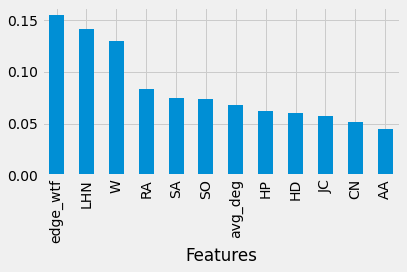

In [50]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)

# Predictiong Graph in 2015

#### Load dataset

In [10]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2015/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2015/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,0.049,0.017,424.449,53.643,39.893,0.854,0.836,0.080,2.925,2.925,1.672,1121.500
1,0.150,0.053,444.948,56.663,16.776,0.895,0.850,0.034,3.222,3.222,1.700,1134.000
2,3.128,1.114,1115.919,155.701,2.245,1.782,0.994,0.004,17.522,17.522,1.987,1736.500
3,4.008,1.428,1373.313,189.456,2.763,1.552,0.994,0.003,21.516,21.516,1.987,1818.500
4,0.044,0.016,418.365,52.631,41.917,0.842,0.825,0.084,2.746,2.746,1.650,1108.000


In [11]:
X_test.shape

(812808, 12)

In [52]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  533639
Negative_samples:  36168


### Up-Sampling

In [32]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [53]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [54]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [55]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [56]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [57]:
prediction = classifier.predict(X_test)

In [58]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.878
1,Precision,0.883
2,Recall,0.992
3,FPR,0.904
4,FNR,0.008
5,F1,0.934


'Feature Importance'

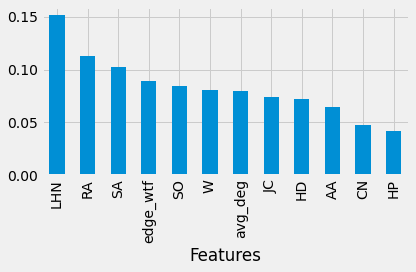

In [59]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)


# Predictiong Graph in 2016

#### Load dataset

In [12]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2016/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2016/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,4.118,1.373,1485.990,196.634,2.066,1.917,0.994,0.003,20.026,20.026,1.988,2127.000
1,6.901,2.300,1870.620,243.511,2.600,1.605,0.992,0.002,23.992,23.992,1.985,2164.000
2,0.070,0.023,657.900,80.068,55.780,0.915,0.900,0.078,4.278,4.278,1.800,1480.500
3,7.119,2.373,1878.366,244.505,2.611,1.600,0.992,0.002,24.105,24.105,1.984,2169.500
4,0.890,0.297,880.866,115.848,5.257,1.224,0.993,0.007,11.022,11.022,1.986,1915.500


In [13]:
X_test.shape

(1193191, 12)

In [61]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  709355
Negative_samples:  103453


### Up-Sampling

In [ ]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [62]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [63]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [64]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [65]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [66]:
prediction = classifier.predict(X_test)

In [67]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.893
1,Precision,0.956
2,Recall,0.929
3,FPR,0.674
4,FNR,0.071
5,F1,0.942


'Feature Importance'

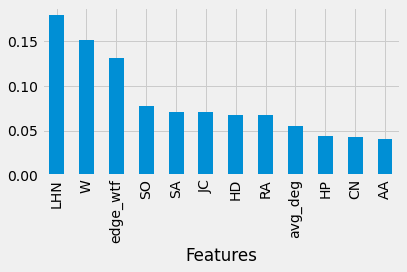

In [68]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)

# Predictiong Graph in 2017

#### Load Dataset

In [14]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2017/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2017/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,0.169,0.053,414.854,54.221,6.543,1.161,0.986,0.018,4.840,4.840,1.972,1974.000
1,0.199,0.063,495.048,62.822,3.438,1.386,0.988,0.010,4.690,4.690,1.975,1945.500
2,0.010,0.003,318.145,37.699,23.290,0.891,0.858,0.065,1.561,1.561,1.716,1428.000
3,0.140,0.044,379.742,47.257,8.066,1.063,0.939,0.023,2.867,2.867,1.878,1643.000
4,0.740,0.234,926.439,115.601,2.593,1.614,0.995,0.005,8.564,8.564,1.989,2147.000


In [15]:
X_test.shape

(1609962, 12)

In [70]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  1121767
Negative_samples:  71424


### Up-Sampling

In [ ]:
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=272827,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [71]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [72]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [73]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 3, 1: 1})

* Training

In [74]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 3, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [75]:
prediction = classifier.predict(X_test)

In [76]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.927
1,Precision,0.939
2,Recall,0.985
3,FPR,0.812
4,FNR,0.015
5,F1,0.962


'Feature Importance'

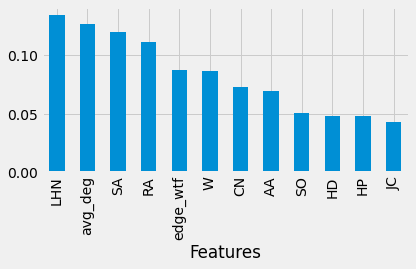

In [77]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)


# Predictiong Graph in 2018

#### Load dataset

In [16]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2018/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2018/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,5.673,1.708,2127.190,262.476,2.188,1.823,0.995,0.002,22.487,22.487,1.989,2972.000
1,6.133,1.846,2403.414,294.904,2.473,1.665,0.995,0.002,24.661,24.661,1.990,3004.000
2,4.036,1.215,1886.737,229.741,2.043,1.941,0.995,0.002,17.364,17.364,1.991,2785.000
3,4.650,1.400,2096.511,255.846,2.157,1.848,0.995,0.002,20.506,20.506,1.991,2923.500
4,5.865,1.766,2271.200,277.453,2.337,1.732,0.995,0.002,21.477,21.477,1.989,2862.000


In [17]:
X_test.shape

(1833248, 12)

In [93]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  1493110
Negative_samples:  116852


### Up-Sampling

In [94]:
df_majority = training_df[training_df.label==1]
df_minority = training_df[training_df.label==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1493110,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576

* define evaluation function

In [95]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [96]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

* choose a ML algorithm

In [97]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, criterion="entropy", 
                                    class_weight={0: 1, 1: 1})

* Training

In [98]:
classifier.fit(X_train, Y_train)

RandomForestClassifier(class_weight={0: 1, 1: 1}, criterion='entropy',
                       max_depth=20, random_state=0)

* Make a predict

In [99]:
prediction = classifier.predict(X_test)

In [100]:
display(evaluate_model(prediction, Y_test))

,Measure,Source
0,Accuracy,0.760
1,Precision,0.773
2,Recall,0.940
3,FPR,0.696
4,FNR,0.060
5,F1,0.848


'Feature Importance'

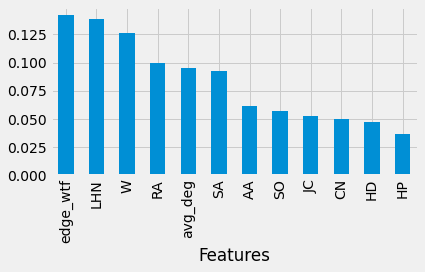

In [86]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)


# Predictiong Graph in 2019

* Load training and testing dataframes

In [7]:
with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2019/train/dataframe.csv", newline='') as csvfile:
    training_df = pd.read_csv(csvfile)
    
training_df['avg_deg'] = (training_df['deg_e1']+training_df['deg_e2'])/2
training_df = training_df.drop(['deg_e1', 'deg_e2'], axis=1)
training_df = training_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]

X_train = training_df.iloc[:,2:-1]
Y_train = training_df.iloc[:]['label']

X_train.head()

with open("/home/c6/Desktop/OpenWPM/jsons/Prediction_new/WT/2019/test/dataframe.csv", newline='') as csvfile:
    testing_df = pd.read_csv(csvfile)

testing_df['avg_deg'] = (testing_df['deg_e1']+testing_df['deg_e2'])/2
testing_df = testing_df.drop(['deg_e1', 'deg_e2'], axis=1)
testing_df = testing_df[['e1','e2','edge_wtf','W','CN','AA','HP','HD','JC','LHN','RA','SA','SO','avg_deg','label']]


X_test = testing_df.iloc[:,2:-1]
Y_test = testing_df.iloc[:]['label']

X_test.head()

,edge_wtf,W,CN,AA,HP,HD,JC,LHN,RA,SA,SO,avg_deg
0,1.899,0.549,1708.032,194.985,4.341,1.288,0.994,0.003,9.047,9.047,1.987,2529.500
1,2.060,0.595,2651.059,296.884,6.738,1.166,0.994,0.003,12.877,12.877,1.988,2657.500
2,1.849,0.535,1510.486,170.146,3.839,1.342,0.994,0.003,7.135,7.135,1.989,2369.000
3,1.953,0.565,1729.305,198.571,4.395,1.283,0.993,0.003,9.745,9.745,1.986,2607.500
4,1.999,0.578,2101.484,237.727,5.341,1.221,0.994,0.003,10.557,10.557,1.988,2534.500


In [9]:
X_test.shape

(2604893, 12)

In [8]:
positive_samples = 0
negative_sample = 0
for i in Y_train:
    if i==1:
        positive_samples += 1 
    else:
        negative_sample += 1

print("Positive Samples: ", positive_samples)
print("Negative_samples: ", negative_sample)

Positive Samples:  1312869
Negative_samples:  520379


### upsample minority class

In [88]:
# Separate majority and minority classes
df_majority = training_df[training_df.label==0]
df_minority = training_df[training_df.label==1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=6171504,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.label.value_counts()
X_train = df_upsampled.iloc[:,2:-1]
Y_train = df_upsampled.iloc[:]['label']
# 1    576
# 0    576
# Name: balance, dtype: int64

* define evaluation function

In [ ]:
def evaluate_model(predictions, actual):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(predictions)): 
        if actual[i]==predictions[i]==1:
            TP += 1
        if predictions[i]==1 and actual[i]!=predictions[i]:
            FP += 1
        if actual[i]==predictions[i]==0:
            TN += 1
        if predictions[i]==0 and actual[i]!=predictions[i]:
            FN += 1
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall", "FPR", "FNR", "F1"],
        "Source": [accuracy_score(actual, predictions), 
                   precision_score(actual, predictions), 
                   recall_score(actual, predictions),
                   FP/(FP+TN),
                   FN/(FN+TP),
                   f1_score(actual, predictions)]
    })

* Find important features

In [ ]:
def feature_importance(columns, classifier):
    display("Feature Importance")
    df = pd.DataFrame({"Features": columns,
                      "Importance": classifier.feature_importances_})
    df = df.sort_values("Importance", ascending=False)
    ax = df.plot(kind='bar', x='Features', y='Importance', legend=None)
    #ax.xaxist.set_label_text("")
    plt.tight_layout()
    plt.show

 ### choose a ML algorithm 

### 1. Random Forest

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, criterion="entropy", class_weight={0: 1, 1: 2}
)

### 2. SVM

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, criterion="entropy", class_weight={0: 1, 1: 2}
)

### 2. SVM

In [53]:
classifier = SVC(kernel='linear', class_weight='balanced', probability=True)

### 3. MLP

In [15]:
classifier = MLPClassifier(random_state=1, max_iter=300, activation='tanh', learning_rate='adaptive')

### 4. Naive Bayes

In [31]:
#classifier = GaussianNB()
classifier = ComplementNB()
#classifier = MultinomialNB()
#classifier = BernoulliNB()

### Train and predict

In [ ]:
classifier.fit(X_train, Y_train)

In [ ]:
prediction = classifier.predict(X_test)

In [ ]:
np.unique(prediction)

In [ ]:
display(evaluate_model(prediction, Y_test))

In [ ]:
columns = ['edge_wtf', 'W', 'CN', 'AA', 'HP', 'HD', 'JC', 'LHN', 'RA', 'SA', 'SO', 'avg_deg']
feature_importance(columns, classifier)